In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag

In [3]:
from iam.all_three_layers import IAM, features_binary, alphabet, corpus, FeatureLayer, feature_count, Connection

In [4]:
iam = IAM()

# Present the ambiguous input

We need to present features consistent with both 'WORK' and 'WORR'

Features that are both in K and R

In [5]:
rk_common_features = [min(K_f, K_r) for (K_f, K_r) in zip(features_binary['K'], features_binary['R'])]
rk_common_features

[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

All features

In [6]:
ambiguous_input = np.array([
    features_binary['W'],
    features_binary['O'],
    features_binary['R'],
    rk_common_features
])
ambiguous_input

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

In [7]:
def present_ambiguous_input():
    iam.feature_layer.activations = ambiguous_input.astype(float)

# Test

In [8]:
def get_letter_activation(position, letter):
    return iam.letter_layer.activations[position, alphabet.index(letter)]

In [9]:
def get_word_activation(word):
    word_index = corpus.word.tolist().index(word.lower())
    return iam.word_layer.activations[word_index]

In [10]:
def take_snapshot():
    for letter, activation_list in letter_activations_history.items():
        activation_list.append(get_letter_activation(position=3, letter=letter))
        
    for word, activation_list in word_activations_history.items():
        activation_list.append(get_word_activation(word))

In [11]:
letter_activations_history = dict(K=[], R = [], D = [])
word_activations_history = dict(WORK=[], WORD=[], WEAK=[], WEAR=[])

iam.reset_nodes()
present_ambiguous_input()

take_snapshot()
for _ in range(40):
    iam.run_cycle()
    take_snapshot()

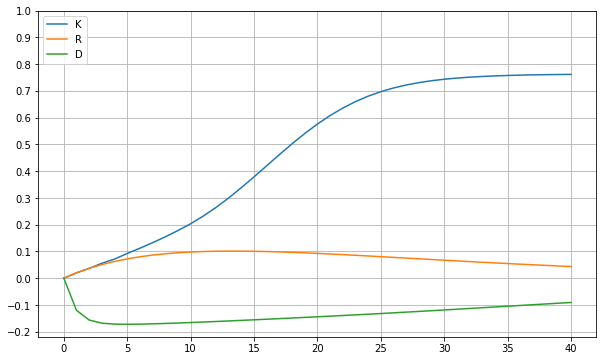

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(letter_activations_history.values())).T)
plt.legend(list(letter_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_letter-activation-plots.png)

- In our simulation, "D" gets uninhibited, in the article, "D" stayst at -0.2
- In our simulation, "R" gets a bit activated (~0.1) and then decays towards 0, in the article, "R" grows steadily towards ~0.35

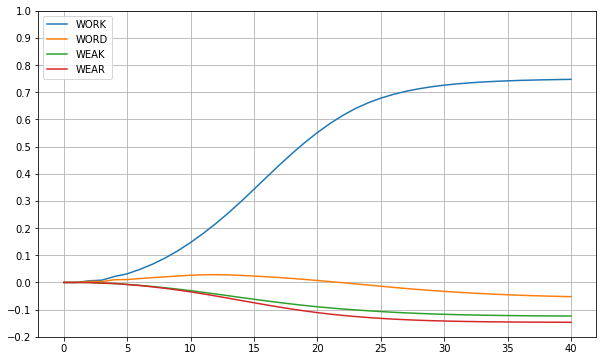

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(word_activations_history.values())).T)
plt.legend(list(word_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_word-activation-plots.png)

- "WORD" get less activate at the peak (~0.03) than in the article (~0.1).
- "WEAK" and "WEAR" plateau later in our simulation.

# Absence detectors

There are two main differences between our implementation and the one from the article:
- we don't have absence detectors,
- word resting levels do not depend on the frequency.

More likely, it is the absence detectors that drive the difference in letter activations.
There are fewer feature nodes to excite "R" (absence detectors of features absent in both "R" and "K") and inhibit "D" (features absent in "R" and "K" but present in "D").

In [14]:
class AbsenceDetectorLayer(FeatureLayer):
    def present_word(self, word):
        """Show a word to the model"""
        features_absent = 1 - np.array([features_binary[letter] for letter in word])
        # Set features absent in the word to the maximum activation
        self.activations = self.maximum_activation * features_absent

class IAMWithAbsenceDetectors(IAM):
    def __init__(self):
        super().__init__()
        
        self.absence_detector_layer = AbsenceDetectorLayer(
            shape=(self.position_count, feature_count),
            resting_activation=0,
            minimum_activation=self.m,
            maximum_activation=self.M,
            decay_rate=self.theta)
        
        self._layers.append(self.absence_detector_layer)
        
        # Feature-to-letter-connections
        # Each detected absent feature excites letters that don't contain this feature and inhibits those that do
        is_excitatory = 1 - np.array([features_binary[letter]
                                      for letter 
                                      in sorted(features_binary.keys())]).T
        # For one letter
        feature_to_letter_excitatory = 0.005
        feature_to_letter_inhibitory = 0.15
        absence_detector_to_letter_weights_1 = np.where(
            is_excitatory,
            feature_to_letter_excitatory,
            - feature_to_letter_inhibitory
        )
        # For all letters
        absence_detector_to_letter_weights = block_diag(
            *[absence_detector_to_letter_weights_1 for _ in range(4)])
        absence_detector_to_letter_connection = Connection(
            layer_from=self.absence_detector_layer,
            layer_to=self.letter_layer,
            weights=absence_detector_to_letter_weights
        )
        
    def present_word(self, word):
        # Feature presence layer
        super().present_word(word)
        self.absence_detector_layer.present_word(word)
        
    def get_letter_activation(self, position, letter):
        return self.letter_layer.activations[position, alphabet.index(letter)]
    
    def get_word_activation(self, word):
        word_index = corpus.word.tolist().index(word.lower())
        return self.word_layer.activations[word_index]

In [15]:
iam_with_absence_detectors = IAMWithAbsenceDetectors()

In [16]:
rk_common_absent_features = [1 - max(K_f, K_r) for (K_f, K_r) in zip(features_binary['K'], features_binary['R'])]
rk_common_absent_features

[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]

In [17]:
ambiguous_input_present_features = np.array([
    features_binary['W'],
    features_binary['O'],
    features_binary['R'],
    rk_common_features
])
ambiguous_input_present_features

array([[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]])

In [18]:
ambiguous_input_absent_features = np.array([
    1 - np.array(features_binary['W']),
    1 - np.array(features_binary['O']),
    1 - np.array(features_binary['R']),
    rk_common_absent_features
])
ambiguous_input_absent_features

array([[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]])

In [19]:
def present_ambiguous_input_2():
    iam_with_absence_detectors.feature_layer.activations = ambiguous_input_present_features.astype(float)
    iam_with_absence_detectors.absence_detector_layer.activations = ambiguous_input_absent_features.astype(float)

In [20]:
def take_snapshot_2():
    for letter, activation_list in letter_activations_history.items():
        activation_list.append(iam_with_absence_detectors.get_letter_activation(position=3, letter=letter))
        
    for word, activation_list in word_activations_history.items():
        activation_list.append(iam_with_absence_detectors.get_word_activation(word))

In [21]:
letter_activations_history = dict(K=[], R = [], D = [])
word_activations_history = dict(WORK=[], WORD=[], WEAK=[], WEAR=[])

iam_with_absence_detectors.reset_nodes()

take_snapshot_2()
present_ambiguous_input_2()

for _ in range(40):
    iam_with_absence_detectors.run_cycle()
    take_snapshot_2()

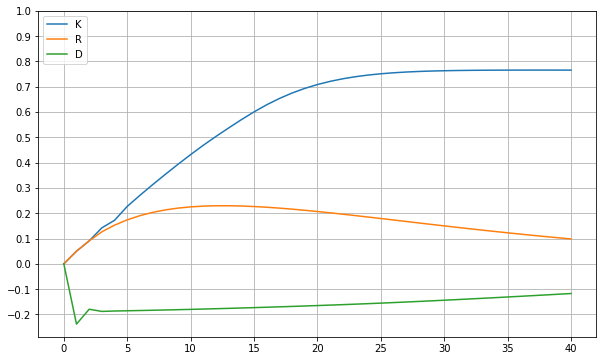

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(letter_activations_history.values())).T)
plt.legend(list(letter_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_letter-activation-plots.png)

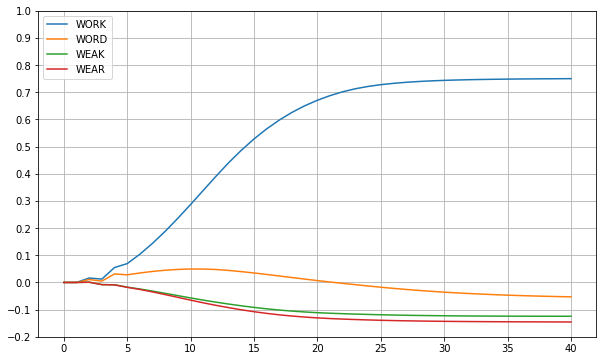

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(word_activations_history.values())).T)
plt.legend(list(word_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

# Present the stimulus constantly

The problem seems to be with the feature nodes decaying. 
We will now imitate constant presentation of the stimulus that will override the decay.

![](work-word_word-activation-plots.png)

In [24]:
letter_activations_history = dict(K=[], R = [], D = [])
word_activations_history = dict(WORK=[], WORD=[], WEAK=[], WEAR=[])

iam_with_absence_detectors.reset_nodes()

take_snapshot_2()

for _ in range(40):
    present_ambiguous_input_2()
    iam_with_absence_detectors.run_cycle()
    take_snapshot_2()

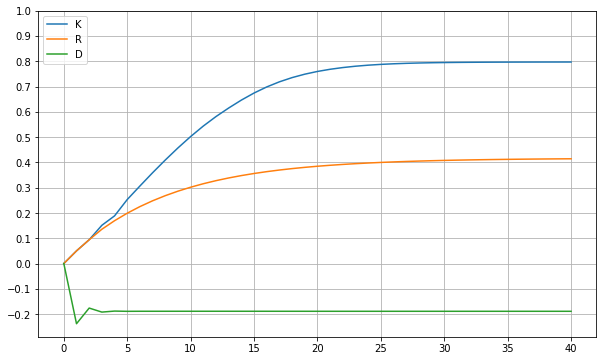

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(letter_activations_history.values())).T)
plt.legend(list(letter_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_letter-activation-plots.png)

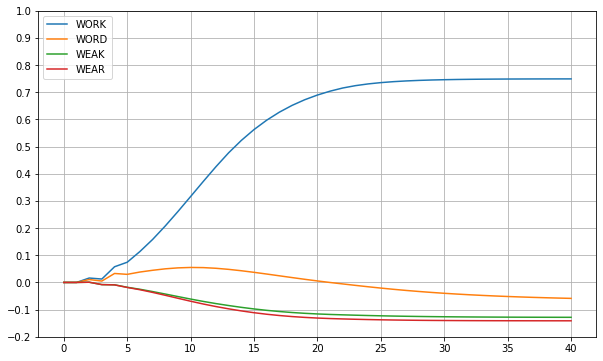

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(list(word_activations_history.values())).T)
plt.legend(list(word_activations_history.keys()), loc='upper left')
plt.grid()
plt.yticks(np.arange(-0.2, 1.1, 0.1));

![](work-word_word-activation-plots.png)

The plots already look similar.
There are still some differences:
- "D" gets inhibited too fast
- "K" and "R" are a tiny little bit more activated
- "D" gets inhibite below the minimum 
- There is jittering of the ativations in the beginning.
- "WORD does not get activated as much

# Why does "D" get inhibited so much in the first cycle?

## Number of active detectors consistent and inconsistent with "D".

In [27]:
print('Active feature detectors:')
print(rk_common_features)
print()

print('Active absence detectors:')
print(rk_common_absent_features)
print()

print('Features present in "D":')
print(features_binary['D'])

Active feature detectors:
[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

Active absence detectors:
[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]

Features present in "D":
[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]


Inconsistent features: 
- present in R and K but absent from D, or
- absent from R and K but present in D.

In [28]:
in_R_and_K_not_in_D = [1 if rk_f == 1 and d_f == 0 else 0 for rk_f, d_f in zip(rk_common_features, features_binary['D'])]
not_in_R_and_K_in_D = [1 if rk_abs_f == 1 and d_f == 1 else 0 
                       for rk_abs_f, d_f in zip(rk_common_absent_features, features_binary['D'])]

inconsistent_count = sum(in_R_and_K_not_in_D) + sum(not_in_R_and_K_in_D)
print(f'Number of active inconsistent detectors: {inconsistent_count}')

Number of active inconsistent detectors: 8


Inconsistent absent features: .

In [29]:
in_R_and_K_in_D = [1 if rk_f == 1 and d_f == 1 else 0 for rk_f, d_f in zip(rk_common_features, features_binary['D'])]
not_in_R_and_K_not_in_D = [1 if rk_abs_f == 1 and d_f == 0 else 0 
                           for rk_abs_f, d_f in zip(rk_common_absent_features, features_binary['D'])]

consistent_count = sum(in_R_and_K_in_D) + sum(not_in_R_and_K_not_in_D)
print(f'Number of active consistent detectors: {consistent_count}')

Number of active consistent detectors: 2


Each active detector is either consistent or inconsistent with "D". Let's chech this.

In [30]:
assert sum(rk_common_features) + sum(rk_common_absent_features) == inconsistent_count + consistent_count

## Activation of "D" after the first cycle

In [31]:
assert inconsistent_count == 8
assert consistent_count == 2

Each active detector of a consistent feature excites "D" by $0.005$, each inconsistent one inhibits by $0.15$.
The net input is calculated in Formula 1:

$$n_i(t) = \sum_j\alpha_{ij}e_j(t) - \sum_k\gamma_{ik}i_k(t)$$

Therefore, the net input to "D" is 
$$0.005 * 2 - 0.15 * 8 = -1.19$$

The net input is negative, therefore the effect of the input on a node is given by formula 3:

$$\epsilon_i(t)=n_i(t)(a_i(t)-m)$$

The initial activation of "D" is 0, the minimum activation of all nodes is $-0.2$, thus the effect on "D" is 

$$-1.19(0-(-0.2)) = -0.238$$

which is equal to the activation of "D" after the first cycle because it had zero activation before.
Even if we restrict all activations to be between $m$ and $M$, the "D" activation will still reach $m$ after the first cycle, not in ~5 cycles as it did in the paper.

The only other source of "D" activation is the word layer.
And the words are not active before the first cycle.
We have not implemented frequency-dependent resting states for word nodes but those will be negative anyways.

We don't have an explanation for the different initial behavior of "D" and will move on for now.

# Check the implementation in the submodule

In [32]:
from iam.added_absence_detectors import IAM as IAMTest

In [33]:
iam_test = IAMTest()

In [34]:
iam_test.reset_nodes()
iam_with_absence_detectors.reset_nodes()

iam_with_absence_detectors.present_word('WORM')
iam_test.present_word('WORM')

iam_with_absence_detectors.run_n_cycles(40)
iam_test.run_n_cycles(40)

In [35]:
np.allclose(iam_test.feature_layer.activations, 
            iam_with_absence_detectors.feature_layer.activations)

True

In [36]:
np.allclose(iam_test.letter_layer.activations, 
            iam_with_absence_detectors.letter_layer.activations)

True

In [37]:
np.allclose(iam_test.word_layer.activations, 
            iam_with_absence_detectors.word_layer.activations)

True